# Initial results DAS protocol vs scenario with attackers

## DAS protocol

* The network is formed of a single builder that is generating the block with all samples and `N` nodes distributed between validators and regular nodes.
* Builder knows all the validators
* All nodes have a unique 256 bits identifier, following the Kademlia procotol used in DEVP2P.
* We assume DAS protocol works on top of Kademlia DHT. We reuse identifiers and we can use the DHT to discover peers. 
However it is not necessary to use DEVP2P or Kademlia as long as we have nodes with random uniformly distributed identifiers and a way to discover nodes and resolve nodes identifiers to connection parameters.
* Builder divides the hash space into 512*512 sample-specific regions, according to the block matrix.
* Builder transforms the 2D block matrix into a two 1D line of samples (1 line row-wise, and 1 line column-wise, i.e, 1 line row-wise means that after all samples in the first row we continue by the first sample of the second row. 1 line column-wise we mean we first start with all the samples of the first column and then we continue with the samples of the second column)
* We assign each sample with a 256 identifier in the hash space with the double 1D aligment. Every sample is defined by a double id in the hash space, one following row-wise and another column-wise order. This way when fetching rows we can find colocated samples, but also when fetching columns.
* Builder chooses the redundancy factor `redundancy` - the higher `redundancy` the higher overhead but the more resistant the scheme becomes to malicious validators.
* The region of samples is defined as all the validators such that `dict(c, v) <= ((2^256 -1) * redundancy * 2) / N_validators `
* The validator pushes each sample to all the validators within the sample's region (Note that it's done in batches - i.e., the builder connects to each validator and gives them all the samples they should hold).

* When a new block is released, nodes got the samples from builder, according to the redundancy parameter and their identifier. 
After getting the assigned samples, they start the sampling process.
* There are two types of sampling processes: validator sampling and random sampling.
* Validator sampling consists in getting 2 rows and 2 columns of the block matrix.
* Random sampling consists in gettting 75 random samples from any row or column.
* One of the rows and one of the columns to download is choosen by selecting the row or column that the node is already in possession of the highest number of samples from the builder.
* The second row and column to download is selected randomly.
* Validators perform validator sampling and random sampling. 
* Non-validator (regular) nodes they just perform random sampling.
* The validator sampling and random sampling follows the same process with the only difference of the selection of the samples to obtain. 
We call sampling nodes, the nodes requesting samples, and serving nodes the nodes replying with samples:
    - Sampling nodes select a set of replying nodes from a list of known nodes that are within the redundancy range following the id space for the samples requesting (how all nodes of the network are discovered is not included in this initial report, but will be in the following reports. Validators are supposed to know all other validators by default).
    - Sampling nodes send samples requests to the replying nodes selected. Samples requests include the wanted samples (all samples pending to be received are included in the requests).
    - Replying nodes reply with the samples requested they have, and also with known nodes to the same distance, from their Kademlia routing table. This way nodes can easily discover kew nodes in the network.
    - Only Alpha requests can be sent at the same time. After sending initially Alpha requests, a response must be received after sending the next request. Alpha is a configurable parameter.
    - For validator sampling the process is stopped after getting half of the row or column. We consider is not necessary to obtain the rest of the samples, since can be obtained reconstructing.
    - Random sampling process stops when all samples are obtained.

## Malicious protocol

* Some of both validator and regular nodes might be malicious. 
* Malicious behaviour is just ignoring samples requests without sending any response.


## Simulation parameters

* Number of nodes: 5000
* Number of attackers: Range from 0% to 75%
* Number of validators: All nodes are validators
* Redundancy parameter: 2
* Latency between nodes: 5ms - 100ms
* Number of samples per block : 512x512
* Sample size: 512 bytes
* Blocks: 5 blocks simulation.
* Number of random samples fetch: 75. 


The following cell is just loading traces files into a dataframe

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

ops_path = {'DAS': '../logsDasEvil0WithNon/operation.csv', 
            'Evil-0.25': '../logsDasEvil0.25WithNon/operation.csv',
            'Evil-0.5': '../logsDasEvil0.5WithNon/operation.csv',
            'Evil-0.75': '../logsDasEvil0.75WithNon/operation.csv'
           }
#msgs_path = {'DAS': '../logsTest/messages.csv', 
#            'Evil-0.1': '../logsEvil0.1/messages.csv',
#            'Evil-0.2': '../logsEvil0.2/messages.csv',
#            'Evil-0.3': '../logsEvil0.3/messages.csv',
#            'Evil-0.4': '../logsEvil0.4/messages.csv',
#            'Evil-0.5': '../logsEvil0.5/messages.csv'
#           }


builder_address = '83814183170291850251680823880522715558189094423550585243365458794131648333116'

op_df={}
msg_df={}
for key in ops_path:
    op_df[key] = pd.read_csv(ops_path[key],index_col=False,low_memory=False)
#for key in msgs_path:
#    msg_df[key] = pd.read_csv(msgs_path[key],index_col=False,low_memory=False)


In this graph we observe the CDF of the time required by validators to fetch 2 rows and 2 columnns using the DAS protocol, with and without attackers in the simulation, from 0\% to 75\% of malicious in the simulation.
We observe in all cases the validator sampling is completed on time, although when the number of malicious nodes in the network is 75\% the time required to fetch the rows and columns is increased substantially and is close to the time limit of 4 seconds for some nodes.

Text(0.5, 0, 'Operation complete time (ms)')

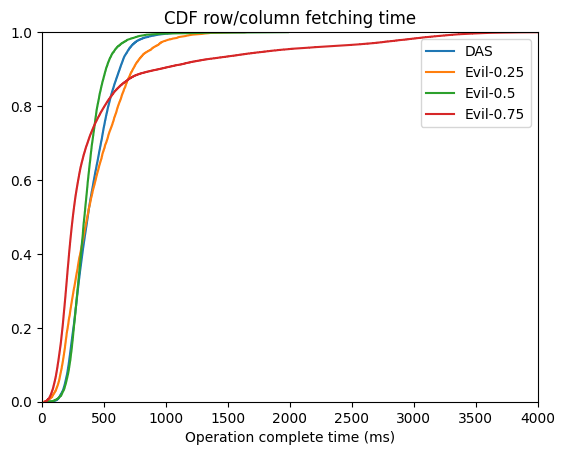

In [2]:
fig3, ax3 = plt.subplots()


for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['completion_time'])
    N = vsdf['completion_time'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax3.plot(x, y,label=key)

ax3.set_xlim([0,4000])
ax3.legend()
ax3.set_ylim([0,1])

ax3.set_title("CDF row/column fetching time")
ax3.set_xlabel("Operation complete time (ms)")

In this graph we observe the CDF of the number of requests required to complete the row and column fetching using the DAS protocol, with and without attackers in the simulation, from 0\% to 75\% of attackers in the simulation.
As we can see in the required time, we see a substantially increase when the number of malicious nodes in the network is very high (75\%)

Text(0.5, 0, '# Messages')

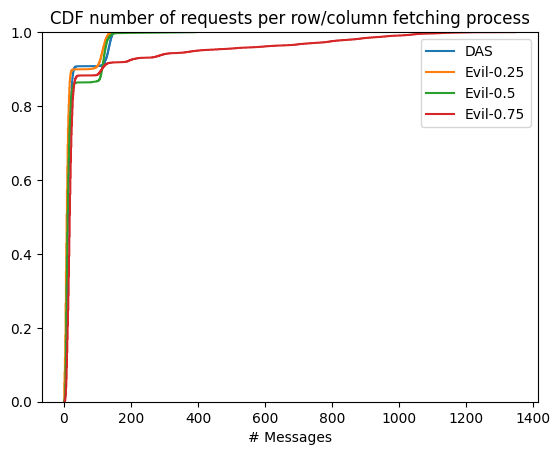

In [3]:
fig8, ax8 = plt.subplots()

for key in op_df:

    vsdf = op_df[key].loc[(op_df[key]['type'] == 'ValidatorSamplingOperation')]

    x = np.sort(vsdf['num_messages'])
    N = vsdf['num_messages'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax8.plot(x, y,label=key)

ax8.legend()
#ax8.set_xlim([0,10])
ax8.set_ylim([0,1])

ax8.set_title("CDF number of requests per row/column fetching process")
ax8.set_xlabel("# Messages")

In this graph we observe the CDF of the time required to complete the random sampling (fetching 75 random samples) of the DAS protocol, with and without attackers in the simulation, from 0\% to 75\% of attackers in the simulation.
In this case we do observe some performance degradation with scenarios with more than 50\% of malicious nodes.
However all nodes manage to finish the random sampling within the deadline of 12 seconds.
The performance degradation is related to the necessity to add complementary method to get samples when sampling fails. These methods are be:
 - Getting missing samples from validators they downloaded the row or column for that sample.
 - Trying to obtain 10 additional samples for each missing sample.


Text(0.5, 0, 'Operation complete time (ms)')

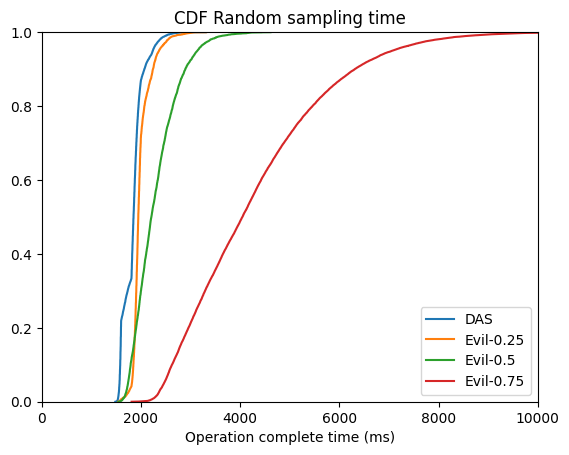

In [4]:
fig4, ax4 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['completion_time'])
    N = rsdf['completion_time'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax4.plot(x, y,label=key)

ax4.legend()
ax4.set_xlim([0,10000])
ax4.set_ylim([0,1])

ax4.set_title("CDF Random sampling time")
ax4.set_xlabel("Operation complete time (ms)")

In this graph we observe the CDF of the number of requests required to complete the random sampling process using the DAS protocol, with and without attackers in the simulation, from 0\% to 75\% of attackers in the simulation.
As we can see in the required time, we see a substantially increase when the number of malicious nodes in the network is very high (75\%)

In [ ]:
fig9, ax9 = plt.subplots()

for key in op_df:

    rsdf = op_df[key].loc[(op_df[key]['type'] == 'RandomSamplingOperation')]

    x = np.sort(rsdf['num_messages'])
    N = rsdf['num_messages'].count()
    # get the cdf values of y
    y = np.arange(N) / float(N)

    ax9.plot(x, y,label=key)

ax9.legend
#ax9.set_xlim([0,500])
ax9.set_ylim([0,1])

ax9.set_title("CDF number of requests per random sampling process")
ax9.set_xlabel("# Messages")